In [10]:
import os
import torch
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_curve, auc, classification_report, accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

### Evaluation of a Vision Transformer Model for Lung Disease Classification

This code evaluates a pre-trained Vision Transformer (ViT) model for classifying lung diseases from chest X-ray images. 

1. **Environment Setup**: The environment is configured to use GPU and sets the appropriate environment variables.
   
2. **Custom Dataset Class**: A `CustomImageDataset` class is defined to load and transform images, applying data augmentation techniques such as random horizontal flips and rotations, resizing, and normalization.

3. **Data Preparation**: The dataset is split into training and testing sets. The testing dataset is loaded using a `DataLoader`.

4. **Model Loading**: The ViT model, pre-trained on a specific dataset, is loaded and moved to the GPU.

5. **Evaluation Function**: The `evaluate_model` function processes the test data through the model, collecting predictions and ground truth labels.

6. **Metrics Calculation**: The code calculates various metrics including accuracy, F1 score, and generates a detailed classification report. Precision-recall and ROC curves are plotted for each disease label.

7. **Visualization**: 
   - Precision-recall curves are plotted to show the trade-off between precision and recall.
   - ROC curves are plotted to visualize the performance across different thresholds.
   - Bar graphs display the accuracy, precision, and sensitivity for each disease label, annotated with their values.



In [11]:
# Load the CSV file
file_path = 'train_df.csv'
train_df_main = pd.read_csv(file_path)

# Map image paths to the DataFrame
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
train_df_main["FilePath"] = train_df_main["Image Index"].map(all_image_paths)

# Drop 'No Finding' column
train_df_main.drop(['No Finding'], axis=1, inplace=True)

# Selected labels
selected_labels = ['Effusion', 'Infiltration', 'Mass', 'Nodule',
                   'Atelectasis', 'Pneumothorax']

# Filter for selected labels
train_df_main = train_df_main[['Image Index', 'FilePath'] + selected_labels]

# Calculate the sum of diseases per patient
train_df_main['Total Diseases'] = train_df_main[selected_labels].sum(axis=1)

# Filter patients with exactly one disease
one_disease_df = train_df_main[train_df_main['Total Diseases'] == 1]

# Calculate the frequency of each disease
disease_counts = one_disease_df[selected_labels].sum()

# Filter diseases with at least 2000 samples
frequent_diseases = disease_counts[disease_counts >= 2000].index.tolist()

# Filter the DataFrame for these frequent diseases
final_df = one_disease_df[one_disease_df[frequent_diseases].eq(1).any(axis=1)]

# Keep only the relevant columns
train_df_main = final_df[['Image Index', 'FilePath'] + frequent_diseases]

train_df_main.columns

Index(['Image Index', 'FilePath', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
       'Atelectasis', 'Pneumothorax'],
      dtype='object')

Using device: cuda:0
Test Accuracy: 0.4369
Test F1 Score: 0.4305
Classification Report:
              precision    recall  f1-score   support

    Effusion       0.67      0.41      0.51      1130
Infiltration       0.61      0.63      0.62      2344
        Mass       0.76      0.21      0.33       520
      Nodule       0.47      0.12      0.19       626
 Atelectasis       0.58      0.37      0.45      1069
Pneumothorax       0.66      0.38      0.48       528

   micro avg       0.62      0.44      0.51      6217
   macro avg       0.63      0.35      0.43      6217
weighted avg       0.62      0.44      0.49      6217
 samples avg       0.44      0.44      0.44      6217



/home/syavari/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


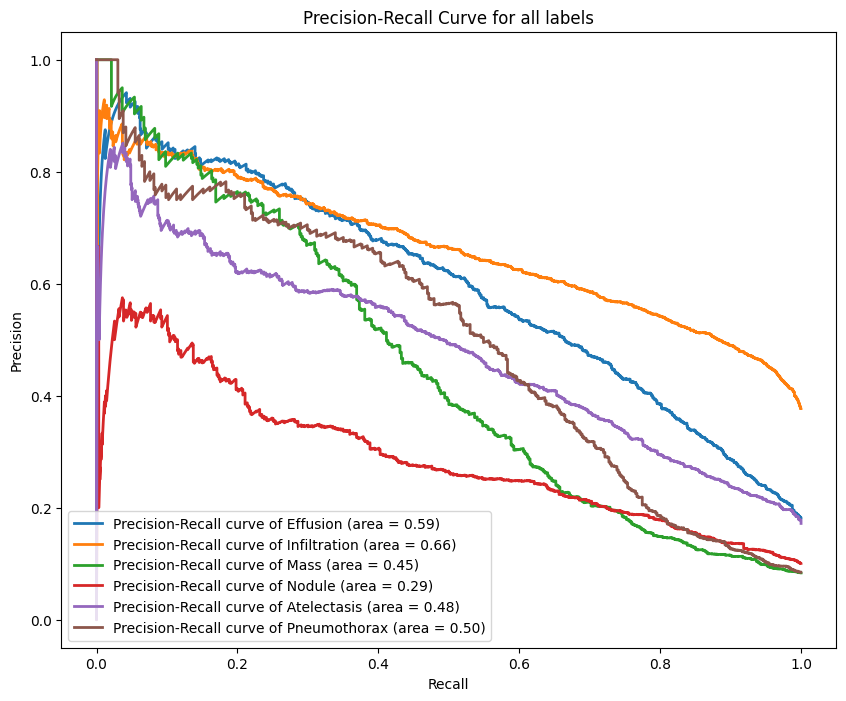

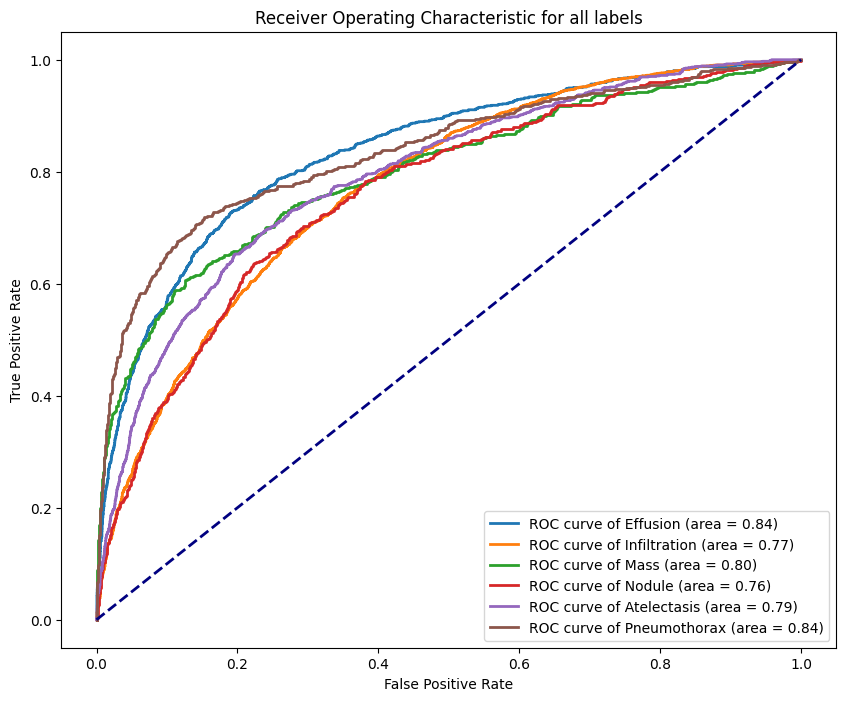

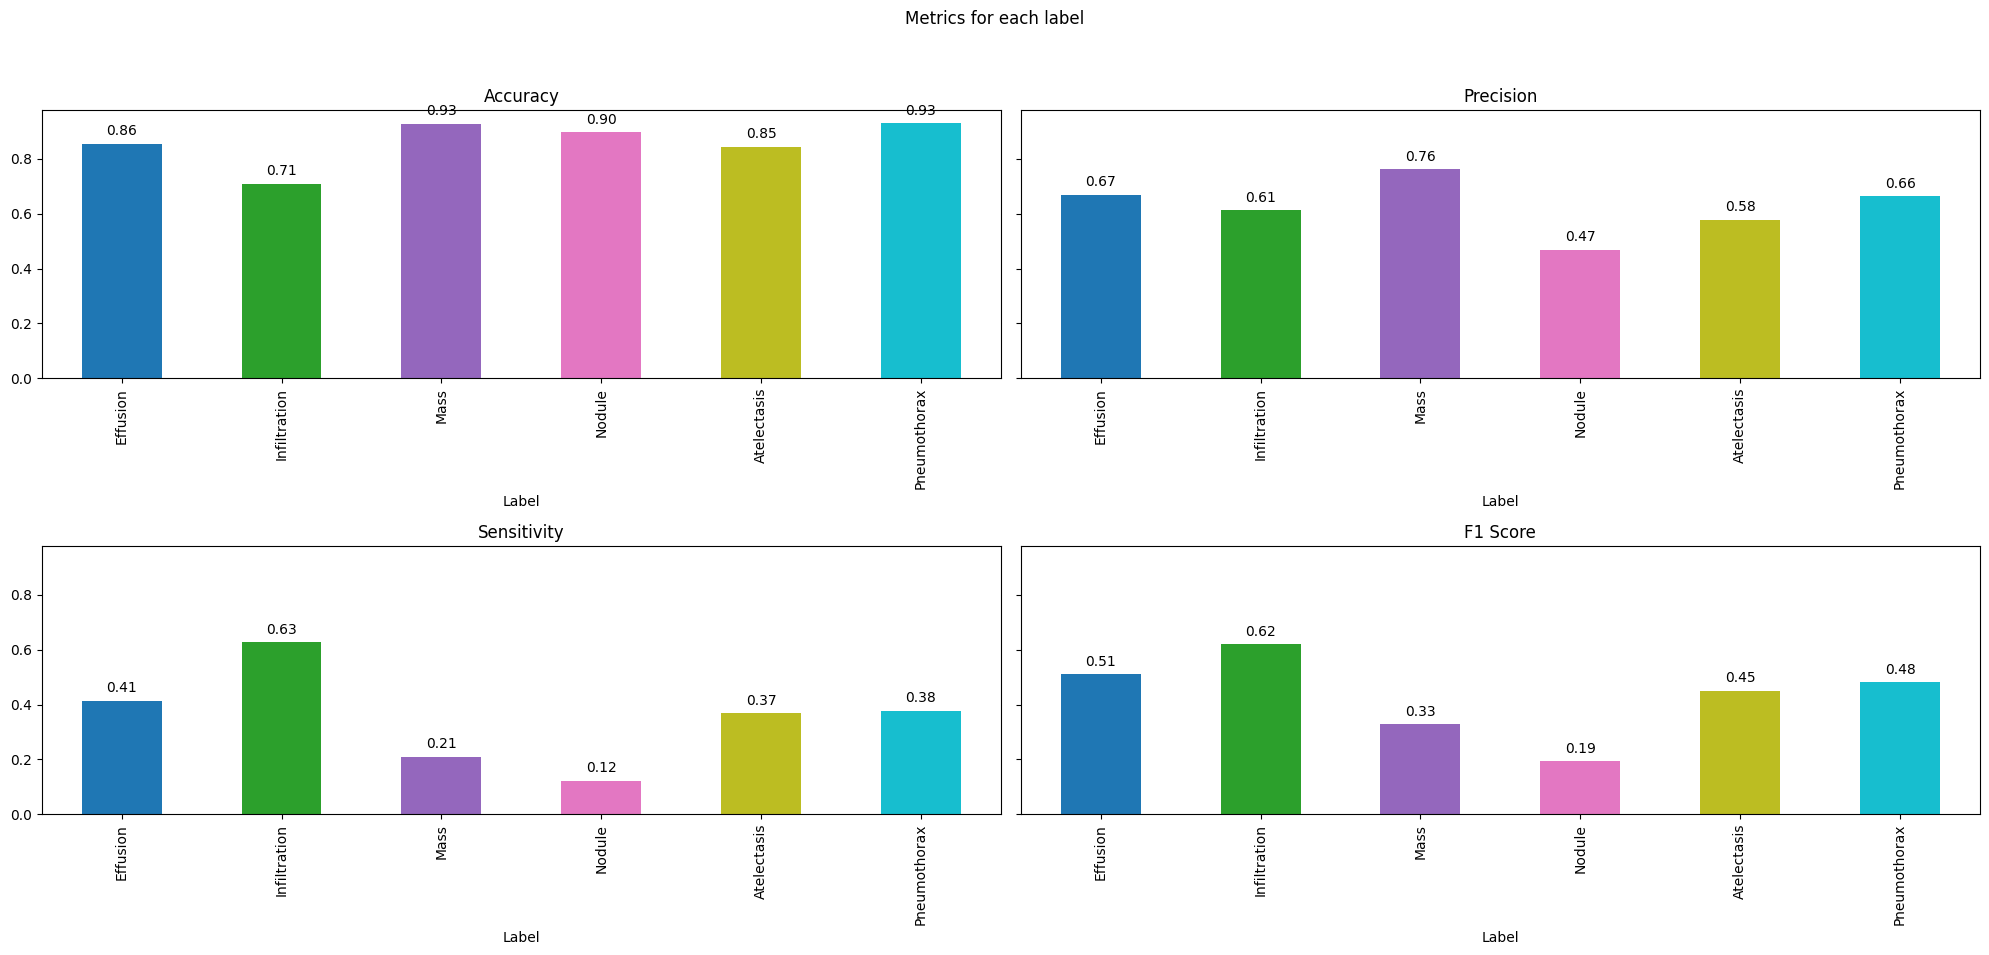

In [12]:

# Ensure you have the right environment variable set for GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

# CustomImageDataset 
class CustomImageDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        self.image_paths = df['FilePath'].values
        self.label_values = df[labels].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label_values[idx], dtype=torch.float32)
        return {"pixel_values": image, "labels": label}

# Custom transform function with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_df, test_df = train_test_split(train_df_main, test_size=0.2, random_state=42)
test_dataset = CustomImageDataset(test_df, frequent_diseases, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the trained model
model_path = './trained_model'
model = ViTForImageClassification.from_pretrained(model_path, num_labels=len(frequent_diseases)).to(device)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval() 
    predictions, labels = [], []
    for batch in dataloader:
        inputs = {"pixel_values": batch["pixel_values"].to(device)}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        predictions.append(logits)
        labels.append(batch["labels"].numpy())
    predictions = np.concatenate(predictions, axis=0)
    labels = np.concatenate(labels, axis=0)
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
    return predictions, labels

# Evaluate the model
predictions, labels = evaluate_model(model, test_loader)

# Calculate metrics
pred_labels = (predictions > 0.5).astype(int)
accuracy = accuracy_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels, average='macro')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(labels, pred_labels, target_names=frequent_diseases))

# Plot precision-recall curves
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    precision, recall, _ = precision_recall_curve(labels[:, i], predictions[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, lw=2, label=f'Precision-Recall curve of {label} (area = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for all labels')
plt.legend(loc="lower left")
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, label in enumerate(frequent_diseases):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of {label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all labels')
plt.legend(loc="lower right")
plt.show()

metrics = []
for i, label in enumerate(frequent_diseases):
    accuracy = accuracy_score(labels[:, i], pred_labels[:, i])
    precision = precision_score(labels[:, i], pred_labels[:, i], zero_division=0)
    sensitivity = recall_score(labels[:, i], pred_labels[:, i], zero_division=0)
    f1 = f1_score(labels[:, i], pred_labels[:, i], zero_division=0)
    metrics.append((label, accuracy, precision, sensitivity, f1))

metrics_df = pd.DataFrame(metrics, columns=['Label', 'Accuracy', 'Precision', 'Sensitivity', 'F1 Score'])

colors = plt.cm.tab10(np.linspace(0, 1, len(frequent_diseases)))

# Plot bar graphs for accuracy, sensitivity, precision, and F1 score
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)
metrics_df.plot(kind='bar', x='Label', y='Accuracy', ax=axes[0, 0], legend=False, color=colors)
axes[0, 0].set_title('Accuracy')
metrics_df.plot(kind='bar', x='Label', y='Precision', ax=axes[0, 1], legend=False, color=colors)
axes[0, 1].set_title('Precision')
metrics_df.plot(kind='bar', x='Label', y='Sensitivity', ax=axes[1, 0], legend=False, color=colors)
axes[1, 0].set_title('Sensitivity')
metrics_df.plot(kind='bar', x='Label', y='F1 Score', ax=axes[1, 1], legend=False, color=colors)
axes[1, 1].set_title('F1 Score')
plt.suptitle('Metrics for each label')

for ax in axes.flat:
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


